## Function to fit our analytical model to the SF-gas from TNG

This fit procedure is also described in section 3 of [van Son et al. 2023](https://ui.adsabs.harvard.edu/abs/2022arXiv220903385V/abstract).



In [1]:
import sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns
import copy

from scipy import interpolate
from scipy.optimize import minimize
from scipy import optimize as opt

# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2015 since that's what TNG uses
from astropy.cosmology import z_at_value
from IPython.display import Image # to open images in Ipython 

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
sys.path.append('../')
import get_ZdepSFRD as Z_SFRD
import importlib
import paths

import ReadFitData as read
importlib.reload(read)

#Change file names to match TNG version
tng=100
Cosmol_sim_location = paths.data / str("SFRMetallicityFromGasTNG%s-1.hdf5"%tng)
fit_filename = 'test_best_fit_parameters_TNG%s-1.txt'%tng
if tng==50:
    rbox=35
elif tng==100:
    rbox=75
elif tng==300:
    rbox=205

if tng==300:
    minimize_method = 'nelder-mead' #nelder-mead, BFGS
else:
    minimize_method = 'BFGS'

# First read the data that you want to fit to
***
We will have simulation data == TNG in our case
Make sure to convert it to a SFDR in Msun/yr/Mpc^-3

model data  == our analytical function

## Make sure you provide at least:

- Sim_SFRD = SFRD(z,Z)/($\Delta$Z), in $\rm{M}_{\odot} \rm{Mpc}^{-3}$
- MetalBins, in metallicity $Z$
- Lookbacktimes, in $\rm{Gyr}$

It is important that you provide the SFRD per dZ bin!! Otherwise your fit will be bin dependent, which is not what you want.. 



In [2]:
Sim_SFRD, Lookbacktimes, Sim_center_Zbin, step_fit_logZ, Redshifts = read.load_TNG(loc = Cosmol_sim_location, rbox=rbox)


### Now we're going to make some cuts 

Because the minimum metallicity in COMPAS is 10^-4, there is no use in fitting to the 10^-7 metallicity tail.

This cuts out the "POP-III" star formation that is happening at 10^-7 in the cosmological simulation. Since we don't capture this kind of stellar evolution in the pop-synth, we don't want to skew our distribution to try and capture that


In [3]:
minZ_popSynth    =  1e-6
## Adjust what metallicities to include 
tofit_Sim_metals = Sim_center_Zbin[np.where(Sim_center_Zbin > minZ_popSynth)[0]]   

## Reverse the time axis of the SFRD and lookback time for the fit
tofit_Sim_SFRD      = Sim_SFRD[:,np.where(Sim_center_Zbin > minZ_popSynth)[0]][::-1]
tofit_Sim_lookbackt = Lookbacktimes[::-1] 

## Convert lookback times to redshifts
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_Sim = Redshifts

## Interpolate the fit data

To ensure that we have a nice and smooth set to compare to 

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [4]:
#########################################
# Interpolate the simulation data
f_interp = interpolate.interp2d(tofit_Sim_lookbackt, tofit_Sim_metals, tofit_Sim_SFRD.T, kind='cubic')

#########################################
# Retrieve values at higher res regular intervals
redshift_new         = np.arange(0, 10.1, 0.05)
Lookbacktimes_new    = [cosmo.lookback_time(z).value for z in redshift_new]

log_tofit_Sim_metals = np.log10(tofit_Sim_metals)
metals_new           = np.logspace(min(log_tofit_Sim_metals), max(log_tofit_Sim_metals), 500)

SFRDnew = f_interp(Lookbacktimes_new,metals_new)
#SFRDnew[SFRDnew < 0] = 0

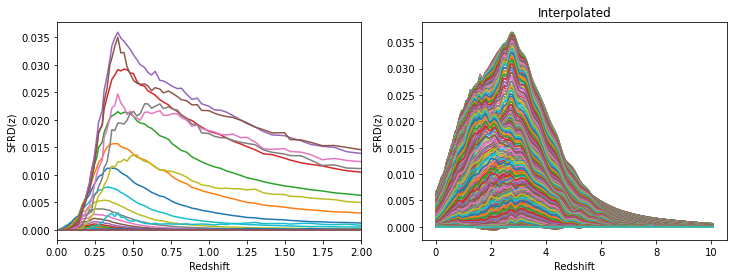

In [5]:
#check what the SFR and interpolated SFRD (with metallicities) look like 
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(redshifts_Sim, tofit_Sim_SFRD)
ax[0].set_xlim(0,2)
ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("SFRD(z)")

ax[1].plot(redshift_new, SFRDnew.T)
ax[1].set_title('Interpolated')
ax[1].set_xlabel("Redshift")
ax[1].set_ylabel("SFRD(z)");

fig.savefig('TNG%s_dataSFRD_z2.png'%tng)

In [6]:
##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = [],  simulation_SFRD = [],
                    mu_0  = 0.026, muz  =-0.09, sigma0  = 1.9, sigmaz  = 1.9, alpha =-3.3,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2):
    """
    Calculate the squared residual of your simulation_SFRD vs your analytical model.
    Args:
        fit_metals        --> [float]          metals used for fit
        Redshifts         --> [float]          redshifts used to fit
        simulation_SFRD   --> [float]          cosmological simulation data to fit to
        
        # metallicity distribution parameters (skew-log-normal)
        mu_0              --> [float]          location (mean in normal) at redshift 0
        muz               --> [float]          redshift evolution of the location
        sigma0            --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz            --> [float]          redshift evolution of Scale (variance in normal)
        alpha             --> [float]          shape (skewness, alpha = 0 retrieves normal dist)
        # overall SFR parameters
        sf_a              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d              --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square    --> [float ] 

    """ 
    #####################################
    # Get the SFR (Shape of Madau & Fragos 2014)
    sfr = Z_SFRD.Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d).value # Msun year-1 Mpc-3 
    # Get dPdZ (skew-log-normal distribution)
    dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(Redshifts,mu_z = muz , mu_0 = mu_0 ,
                                                  omega_0= sigma0 , omega_z=sigmaz , alpha = alpha , 
                                                  metals=fit_metals)
    
    ######################################
    data           = simulation_SFRD                # Model comes in dP/dlogZ, so should your sim-data !
    model          = sfr[:,np.newaxis] * dPdlogZ 

    # The square of the residuals
    res_squared = ((data - model )**2)
    
    # Divide over the sum of the model at each redshift,
    # reduces contribution from high sfr redshifts & increases the weight where sfr is low
    chi_square = res_squared/np.sum(model, axis = 1)[:,np.newaxis]
    
    # Return sum Chi_squared and the max squared residual
    return np.sum(chi_square), data, model  

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [7]:
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2] ):
    chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                       muz  =x0[0], mu_0  =x0[1],sigma0  =x0[2], sigmaz =x0[3], alpha  =x0[4],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8])
    return chi_square

# BEST GUESS
x0     = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])
#        # mu_z        # mu_0     # omega_0 #omega_z  #alpha       #sf_a       #sf_b       #sf_c       #sf_d
bounds = ((-1., 0), (0.001, 0.1), (0.01, 5), (0, 1.), (-10, 0), (None,None),(None,None),(None,None),(None,None))

# FIT
if minimize_method=='BFGS':
    res = minimize(test_chi, x0= x0, method = 'BFGS',options = {'gtol': 0.05})
    
else:
    res = minimize(test_chi, x0= x0, method=minimize_method)
    
# other options include: 'nelder-mead', L-BFGS-B, 'BFGS'
# Alternative: res = opt.basinhopping(test_chi, x0= x0, minimizer_kwargs={'method':'BFGS'})

In [8]:
print(res.success, res.message, 'N iterations: ', res.nit)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4]
sf_a_best, sf_b_best, sf_c_best, sf_d_best               = res.x[5], res.x[6], res.x[7], res.x[8] 

print('\nBEST FITTING PARAMETERS:')
print('mu0 =%s, muz =%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (mu0_best, muz_best, sigma0_best, sigmaz_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )

chi_square, data, model = calc_chi_square(metals_new, Redshifts = redshift_new, simulation_SFRD = SFRDnew.T, 
                                   muz =muz_best, mu_0 =mu0_best,sigma0 =sigma0_best, sigmaz=sigmaz_best,alpha=alpha_best,
                                   sf_a =sf_a_best, sf_b=sf_b_best, sf_c=sf_c_best, sf_d=sf_d_best)
print('chi_square',chi_square, 'max_res_squared', np.amax( (data-model)**2) )

# Calculate standard error on params
from numpy.linalg import inv
N_elements  = len(data.flatten()) 
v = res['fun']/   N_elements  # variance of residuals, sse/n
#var = v*inv(res['hess_inv'])
#se = np.sqrt(np.diag(var))
#print('standard error', se)
# for i, val in enumerate(res['x']):
#     print(np.round(val,3), ' pm ',  np.round(se[i],4) )

True Optimization terminated successfully. N iterations:  36

BEST FITTING PARAMETERS:
mu0 =0.024617731878811815, muz =-0.04852506978783092, sigma_0 =1.119747586650882, sigma_z =0.04983383126521, alpha=-1.7819909142691364
sf_a =0.01683284278060786, sf_b =1.4845096466936307, sf_c =4.440470973043944, sf_d =6.014485743250382
chi_square 0.036742102392302224 max_res_squared 5.1077728926018604e-05


In [9]:
if res.success:
    np.savetxt(paths.data / fit_filename,
               np.c_[mu0_best, muz_best, sigma0_best, sigmaz_best, alpha_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best],
               header = "mu0, muz, omega0, omegaz, alpha0,sf_a, sf_b, sf_c, sf_d", delimiter=',', fmt="%s")


# Check SFRD(Z, z) fit

In [10]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a_best, b=sf_b_best, c=sf_c_best, d=sf_d_best).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz_best , mu_0 = mu0_best ,
                                                  omega_0= sigma0_best , omega_z=sigmaz_best , alpha = alpha_best , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ

In [11]:
Zsun = 0.014 # Solar metallicity
cmap = sns.color_palette('rocket', as_cmap=True)

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/2932090491.py:29: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(data)


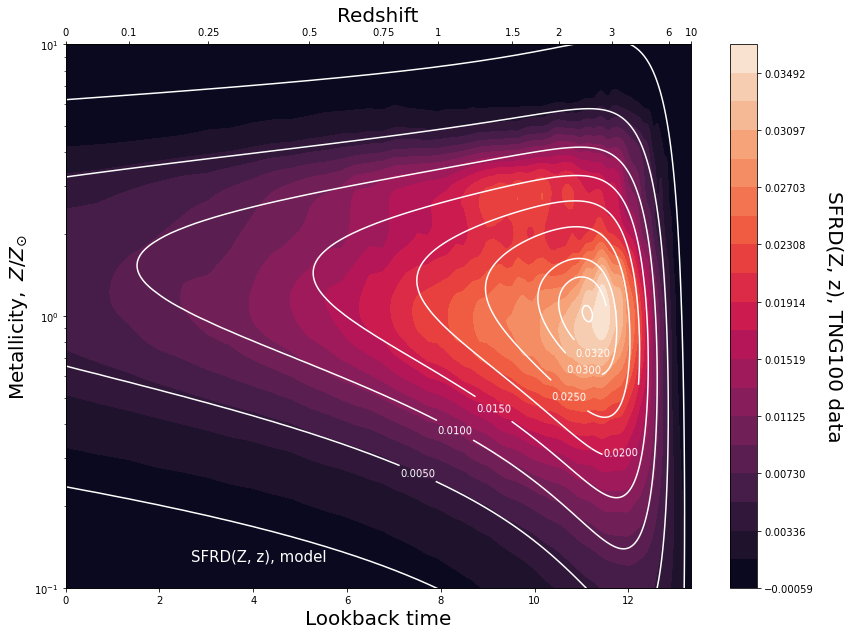

In [12]:
fig, ax = plt.subplots(figsize = (14,10))

levels = np.linspace(np.amin(SFRDnew), np.amax(SFRDnew), 20)
if tng==50:
    clevels = [1e-10, 1e-6, 1e-4, 1e-3, 0.005, 0.01, 0.02, 0.03, 0.04, 0.045, 0.05] #tng50
elif tng==100:
    clevels = [1e-3, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.032, 0.0335] #tng100
elif tng==300:
    clevels = [1e-3, 0.005, 0.01, 0.015,0.02, 0.022, 0.024] #tng300

data = ax.contourf(Lookbacktimes_new, metals_new/Zsun, SFRDnew, levels=levels, cmap=cmap)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.clabel(modelplot, fontsize=10, inline=True)

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.05, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')
ax.set_ylim(10**-1, 10**1)

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))
ax2.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))

cbar = fig.colorbar(data)
cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30)

fig.savefig("SFRD_Z_z_TNG%sinterpolated.png"%tng, bbox_inches='tight')

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/4279012642.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(data)


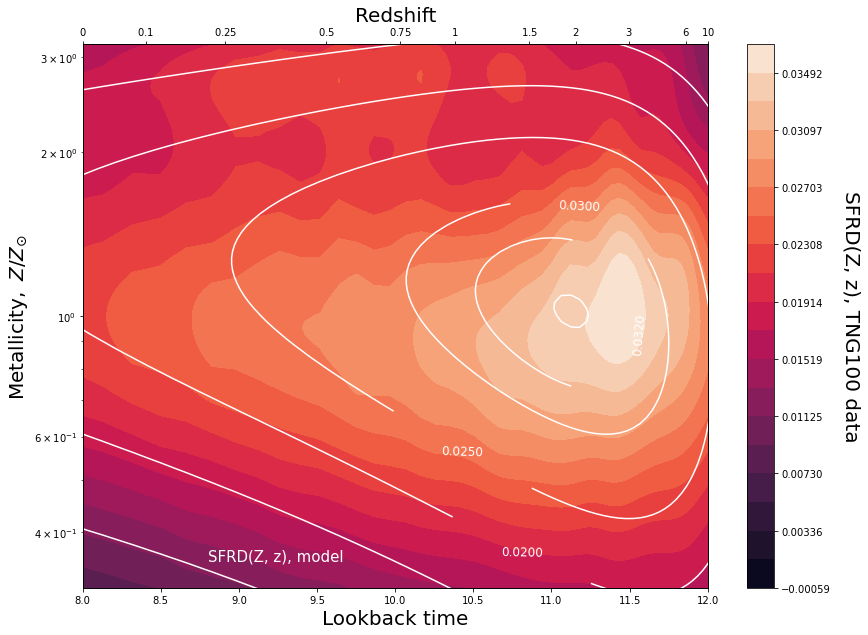

In [13]:
fig, ax = plt.subplots(figsize = (14,10))

data = ax.contourf(Lookbacktimes_new, metals_new/Zsun, SFRDnew, levels=levels, cmap=cmap)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.clabel(modelplot, fontsize=12, inline=True)

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.05, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')
ax.set_xlim(8, 12)
ax.set_ylim(10**-0.5, 10**0.5)
ax2.set_ylim(10**-0.5, 10**0.5)

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
#ax.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))
#ax2.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))

cbar = fig.colorbar(data)
cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30)

fig.savefig("SFRD_Z_z_TNG%scloseup.png"%tng, bbox_inches='tight')

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/2686192233.py:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(data)


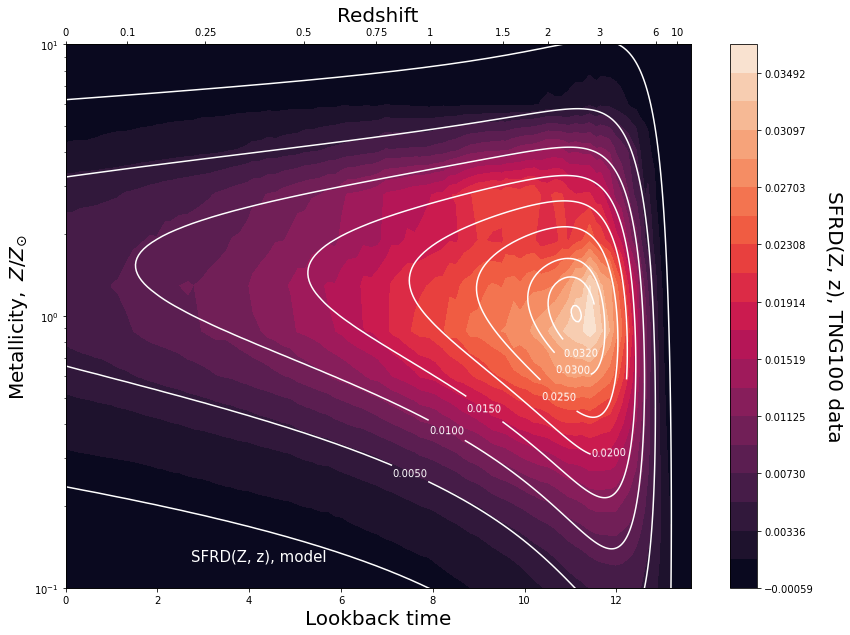

In [14]:
fig, ax = plt.subplots(figsize = (14,10))

data = ax.contourf(tofit_Sim_lookbackt, tofit_Sim_metals/Zsun, tofit_Sim_SFRD.T, levels=levels, cmap=cmap)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.clabel(modelplot, fontsize=10, inline=True) #fmt = '%.1e')

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.05, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')
ax.set_ylim(10**-1, 10**1)

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(tofit_Sim_lookbackt), max(tofit_Sim_lookbackt))
ax2.set_xlim(min(tofit_Sim_lookbackt), max(tofit_Sim_lookbackt))

cbar = fig.colorbar(data)
cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30)

fig.savefig("SFRD_Z_z_TNG%s.png"%tng, bbox_inches='tight')

In [15]:
SFRDnew2 = copy.deepcopy(SFRDnew)
model2 = copy.deepcopy(model.T)
SFRDnew2[SFRDnew2 < 1e-7] = 0
model2[model2 < 1e-7] = 0
diff = model2/SFRDnew2
percenterr = (model2-SFRDnew2)/SFRDnew2

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/3679761760.py:5: RuntimeWarning: divide by zero encountered in divide
  diff = model2/SFRDnew2
/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/3679761760.py:5: RuntimeWarning: invalid value encountered in divide
  diff = model2/SFRDnew2
/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/3679761760.py:6: RuntimeWarning: divide by zero encountered in divide
  percenterr = (model2-SFRDnew2)/SFRDnew2
/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/3679761760.py:6: RuntimeWarning: invalid value encountered in divide
  percenterr = (model2-SFRDnew2)/SFRDnew2


/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/2768984264.py:24: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(model2dplot)


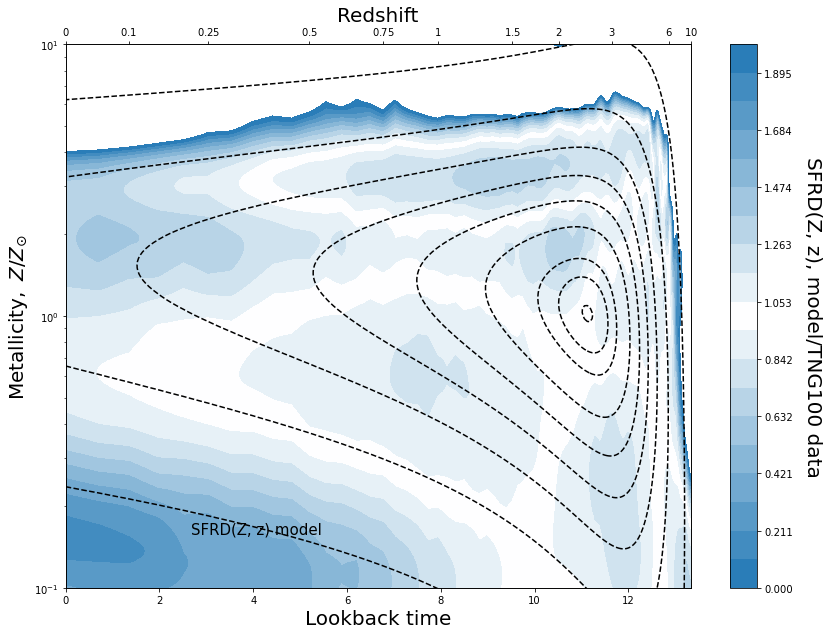

In [16]:
fig, ax = plt.subplots(figsize = (14,10))

levels = np.linspace(0, 2, 20)

cmapdiverge = matplotlib.colors.LinearSegmentedColormap.from_list('', ['tab:blue', 'white', 'tab:blue'])
model2dplot = ax.contourf(Lookbacktimes_new, metals_new/Zsun, diff, levels=levels, cmap=cmapdiverge)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='black', linestyles='dashed')
#ax.clabel(modelplot, fontsize=12, inline=True, fmt = '%.0e')

ax.set_ylim(10**-1, 10**1)
ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.1, "SFRD(Z, z) model", transform=ax.transAxes, fontsize=15, color='black')

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))
ax2.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))

cbar = fig.colorbar(model2dplot)
cbar.set_label('SFRD(Z, z), model/TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30)

fig.savefig("SFRD_Z_z_TNG%sdiff.png"%tng, bbox_inches='tight')

## 2D histograms

In [17]:
SFRDs = []
for i, val in enumerate(metals_new):
    SFRDatZ = SFRDnew[i]
    metalsatZ = metals_new[i]*np.ones(len(SFRDatZ))
    modelatZ = model.T[i]
    
    if len(SFRDs) == 0:
        SFRDs = SFRDatZ
        Zs = metalsatZ
        redshifts = redshift_new
        lookbackts = Lookbacktimes_new
        models = modelatZ
    else:
        SFRDs = np.concatenate((SFRDs, SFRDatZ))
        Zs = np.concatenate((Zs, metalsatZ))
        redshifts = np.concatenate((redshifts, redshift_new))
        lookbackts = np.concatenate((lookbackts, Lookbacktimes_new))
        models = np.concatenate((models, modelatZ))

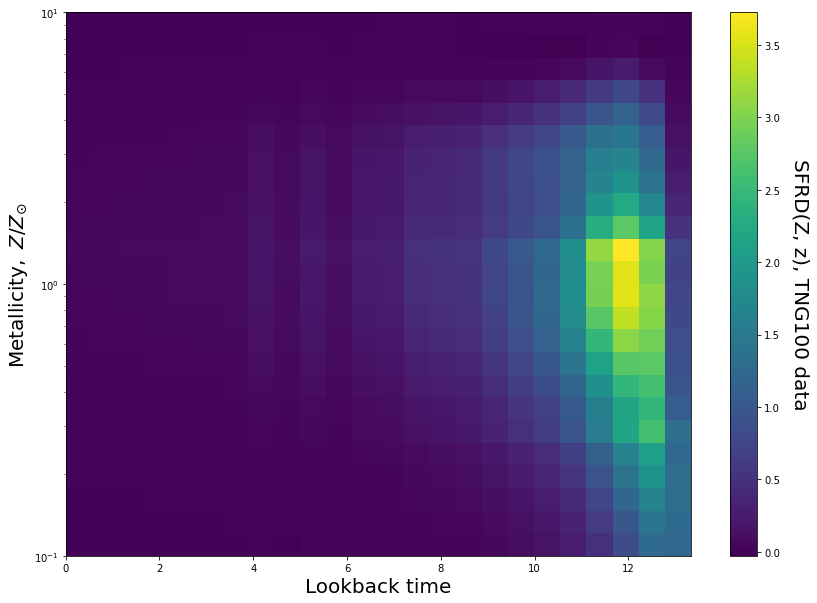

In [18]:
fig, ax = plt.subplots(figsize = (14,10))

xbins = np.linspace(min(lookbackts), max(lookbackts), 25)
#ybins = np.logspace(np.log10(min(Zs/Zsun)), np.log10(max(Zs/Zsun)), 30)
ybins = np.logspace(-1, 1, 25)

dataplot = ax.hist2d(lookbackts, Zs/Zsun, weights=SFRDs, bins=(xbins, ybins));
#modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.set_ylim(10**-1, 10**1)
#ax.text(0.2, 0.1, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')

cbar = fig.colorbar(dataplot[3])
cbar.set_label('SFRD(Z, z), TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30);
fig.savefig('sfrd_2dhist_TNG%s.png'%tng, bbox_inches='tight')

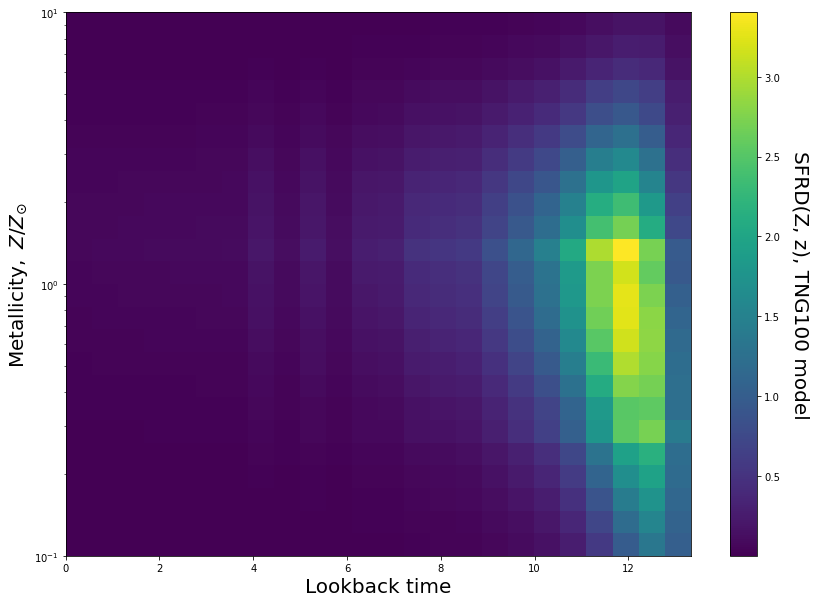

In [19]:
fig, ax = plt.subplots(figsize = (14,10))

modelplot = ax.hist2d(lookbackts, Zs/Zsun, weights=models, bins=(xbins, ybins));
#ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
#ax.text(0.2, 0.1, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')
ax.set_ylim(10**-1, 10**1)
cbar = fig.colorbar(modelplot[3])
cbar.set_label('SFRD(Z, z), TNG%s model'%tng, rotation=270, fontsize=20, labelpad=30);
fig.savefig('sfrd_2dhist_model_TNG%s.png'%tng, bbox_inches='tight')

In [20]:
histvals = []
modelvals = []
xcenters = (dataplot[1][:-1] + dataplot[1][1:]) / 2
ycenters = (dataplot[2][:-1] + dataplot[2][1:]) / 2
for i, val in enumerate(xcenters):
    dataatx = dataplot[0][i]
    modelatx = modelplot[0][i]
    xsatx = xcenters[i]*np.ones(len(dataatx))
    
    if len(histvals) == 0:
        histvals = dataatx
        modelvals = modelatx
        xs = xsatx
        ys = ycenters
    else:
        histvals = np.concatenate((histvals, dataatx))
        modelvals = np.concatenate((modelvals, modelatx))
        xs = np.concatenate((xs, xsatx))
        ys = np.concatenate((ys, ycenters))
        
diff = modelvals/histvals
percentdiff = (modelvals-histvals)/histvals

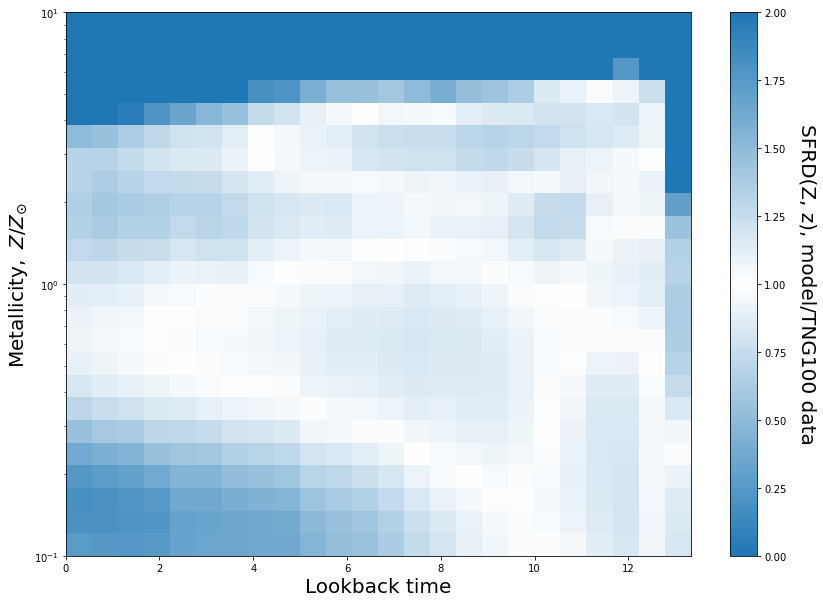

In [21]:
fig, ax = plt.subplots(figsize = (14,10))

diffplot = ax.hist2d(xs, ys, weights=diff, bins=(dataplot[1], dataplot[2]), vmin = 0, vmax=2, cmap=cmapdiverge);
#modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='black', linestyles='dashed')
#ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
#ax.text(0.2, 0.1, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')
ax.set_ylim(10**-1, 10**1)

cbar = fig.colorbar(diffplot[3])
cbar.set_label('SFRD(Z, z), model/TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30);

fig.savefig('sfrd_2dhist_diff_TNG%s.png'%tng, bbox_inches='tight')

# dP/dlogZ

/var/folders/h0/sdzcqrx17fj53mqjr65dvvjh0000gn/T/ipykernel_9727/4161928481.py:23: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(data)


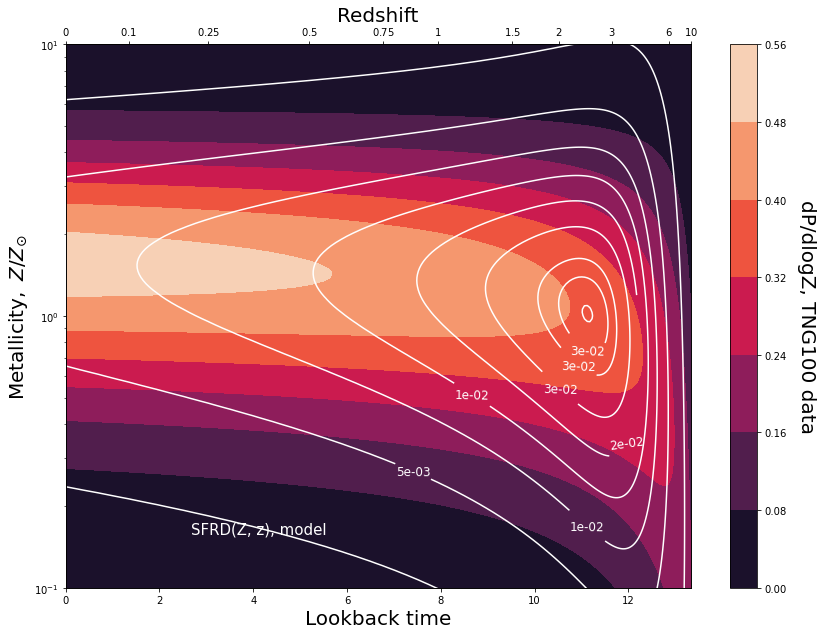

In [22]:
fig, ax = plt.subplots(figsize = (14,10))

#levels = np.linspace(np.amin(dPdlogZ), np.amax(dPdlogZ), 20)

data = ax.contourf(Lookbacktimes_new, metals_new/Zsun, dPdlogZ.T, cmap=cmap)
modelplot = ax.contour(Lookbacktimes_new, metals_new/Zsun, model.T, levels=clevels, colors='white')
ax.clabel(modelplot, fontsize=12, inline=True, fmt = '%.0e')

ax.set_yscale('log')
ax.set_xlabel('Lookback time', fontsize=20)
ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize=20)
ax.text(0.2, 0.1, "SFRD(Z, z), model", transform=ax.transAxes, fontsize=15, color='white')
ax.set_ylim(10**-1, 10**1)

ax2 = ax.twiny()
redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
ax2.set_xlabel('Redshift', fontsize = 20)
ax.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))
ax2.set_xlim(min(Lookbacktimes_new), max(Lookbacktimes_new))

cbar = fig.colorbar(data)
cbar.set_label('dP/dlogZ, TNG%s data'%tng, rotation=270, fontsize=20, labelpad=30)

fig.savefig("dpdlogZ_Z_z_TNG%s.png"%tng, bbox_inches='tight')

# Compare SFRDs

Text(0, 0.5, 'SFRD(Z, z)')

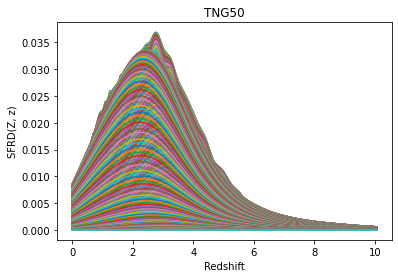

In [27]:
# Get the SFR (Shape of Madau & Fragos 2014)
sfr = Z_SFRD.Madau_Dickinson2014(redshift_new, a=sf_a_best, b=sf_b_best, c=sf_c_best, d=sf_d_best).value # Msun year-1 Mpc-3 
# Get dPdZ (skew-log-normal distribution)
dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                    Z_SFRD.skew_metallicity_distribution(redshift_new ,mu_z = muz_best , mu_0 = mu0_best ,
                                                  omega_0= sigma0_best , omega_z=sigmaz_best , alpha = alpha_best , 
                                                  metals=metals_new)
    

model = sfr[:,np.newaxis] * dPdlogZ
plt.plot(redshift_new, SFRDnew.T); #simulation
plt.plot(redshift_new, model); #fitted model, best fit
plt.title("TNG%s"%tng)
plt.xlabel("Redshift")
plt.ylabel("SFRD(Z, z)")
plt.savefig("figures/checking_fit/SFRD_TNG%s_withmodel.png"%tng)

In [28]:
# Note that in lower res, see clearer two peak shape. Box size affects how wobbly lines are

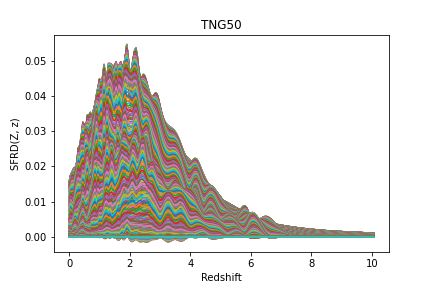

In [29]:
Image(filename='figures/checking_fit/SFRD_TNG50.png') 

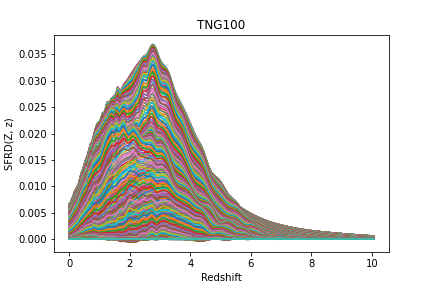

In [30]:
Image(filename='figures/checking_fit/SFRD_TNG100.png') 

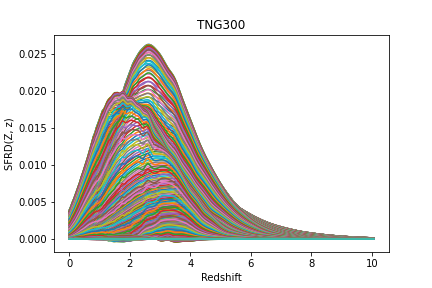

In [31]:
Image(filename='figures/checking_fit/SFRD_TNG300.png') 

In [32]:
#read in data for comparison
with h5.File(paths.data / "SFRMetallicityFromGasTNG100-1.hdf5", "r") as f:
        MetalBins100     = f["MetalBins"][:]
        Lookbacktimes100 = f["Lookbacktimes"][:]
        BoxSfr100      = f["Sfr"][:]
        Redshifts100     = f["Redshifts"][:]
with h5.File(paths.data / "SFRMetallicityFromGasTNG50-1.hdf5", "r") as f:
        MetalBins50     = f["MetalBins"][:]
        Lookbacktimes50 = f["Lookbacktimes"][:]
        BoxSfr50      = f["Sfr"][:]
        Redshifts50     = f["Redshifts"][:]
with h5.File(paths.data / "SFRMetallicityFromGasTNG300-1.hdf5", "r") as f:
        MetalBins300     = f["MetalBins"][:]
        Lookbacktimes300 = f["Lookbacktimes"][:]
        BoxSfr300      = f["Sfr"][:]
        Redshifts300     = f["Redshifts"][:]
with h5.File(Cosmol_sim_location, "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
        Redshifts     = f["Redshifts"][:]
        
littleh  = 0.6774
SFRD50 = (BoxSfr50 / (35/littleh)**3 *u.Mpc**-3).value
SFRD100 = (BoxSfr100 / (75/littleh)**3 *u.Mpc**-3).value
SFRD300 = (BoxSfr300 / (205/littleh)**3 *u.Mpc**-3).value

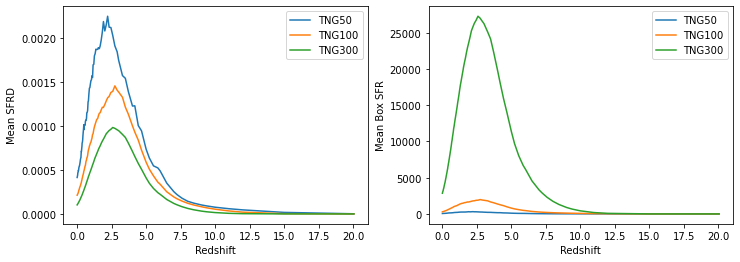

In [33]:
#check what mean Box SFR and SFRD look like for each TNG

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(Redshifts50, np.mean(SFRD50, axis=1), label='TNG50')
ax[0].plot(Redshifts100, np.mean(SFRD100, axis=1), label='TNG100')
ax[0].plot(Redshifts300, np.mean(SFRD300, axis=1), label='TNG300')
ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Mean SFRD")
#ax[0].set_yscale('log')
ax[0].legend();

ax[1].plot(Redshifts50, np.mean(BoxSfr50, axis=1), label='TNG50')
ax[1].plot(Redshifts100, np.mean(BoxSfr100, axis=1), label='TNG100')
ax[1].plot(Redshifts300, np.mean(BoxSfr300, axis=1), label='TNG300')
ax[1].set_xlabel("Redshift")
ax[1].set_ylabel("Mean Box SFR")
#ax[0].set_yscale('log')
ax[1].legend();

# Check my new fits for TNG100

In [34]:
new_vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG100.txt", skiprows=1, delimiter=",")
old_vals = np.loadtxt(paths.data / "test_best_fit_parameters.txt", skiprows=1, delimiter=",")
ticks =  ["mean metallicity at z=0", "redshift evolution of mean", "variance in metallicity density distribution", "redshift evolution of variance", "skewness","SFR scaling", "SFR upward slope", "SFR peak location", "SFR downward slope"]

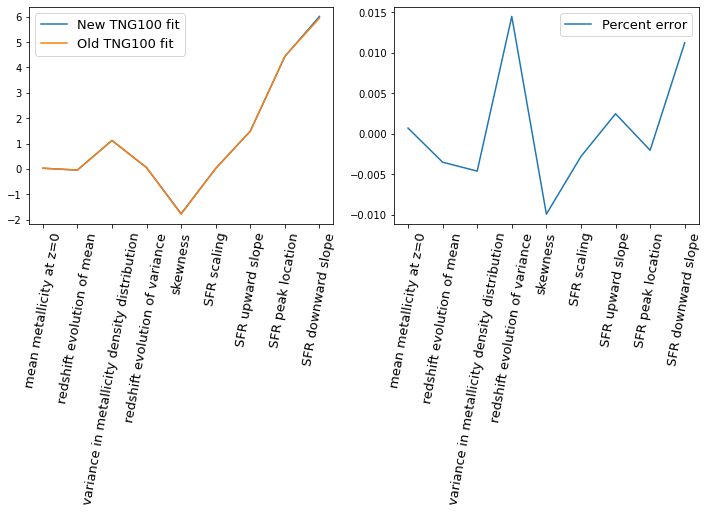

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x = [0,1,2,3,4,5,6,7,8]

ax[0].plot(x, new_vals, label='New TNG100 fit')
ax[0].plot(x, old_vals, label="Old TNG100 fit")
ax[0].set_xticks(x)
ax[0].set_xticklabels(ticks, rotation=80, fontsize=13)
ax[0].legend(fontsize=13);

ax[1].plot(x, (new_vals-old_vals)/old_vals, label='Percent error')
ax[1].set_xticks(x)
ax[1].set_xticklabels(ticks, rotation=80, fontsize=13)
ax[1].legend(fontsize=13);

# Compare fit parameters across TNGs

In [36]:
tng100vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG100.txt", skiprows=1, delimiter=",")
tng50vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG50.txt", skiprows=1, delimiter=",")
tng300vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG300.txt", skiprows=1, delimiter=",")
tng100_2vals = np.loadtxt(paths.data / "test_best_fit_parameters_TNG100-2.txt", skiprows=1, delimiter=",")

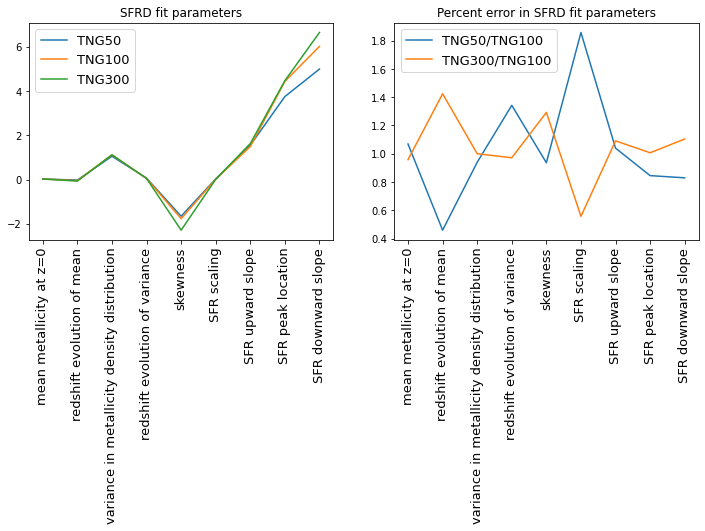

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x = [0,1,2,3,4,5,6,7,8]

ax[0].plot(x, tng50vals, label="TNG50")
ax[0].plot(x, tng100vals, label='TNG100')
ax[0].plot(x, tng300vals, label="TNG300")
ax[0].set_xticks(x)
ax[0].set_xticklabels(ticks, rotation=90, fontsize=13)
ax[0].legend(fontsize=13)
ax[0].set_title('SFRD fit parameters')

ax[1].plot(x, tng50vals/tng100vals, label='TNG50/TNG100')
ax[1].plot(x, tng300vals/tng100vals, label='TNG300/TNG100')
ax[1].set_xticks(x)
ax[1].set_xticklabels(ticks, rotation=90, fontsize=13)
ax[1].legend(fontsize=13)
ax[1].set_title('Percent error in SFRD fit parameters');

fig.savefig('figures/checking_fit/fit_percenterror.png', bbox_inches='tight')

# Visualize the fit

Let's try to visualize how well our fit matches the simulation, by plotting the **squared residuals**:

\begin{equation}
\log_{10} \lvert \mathcal{S}(Z_i, z_j)_{sim} - \mathcal{S}(Z_i, z_j)_{fit} \rvert
\end{equation}


And the relative error


\begin{equation}
\log_{10} \frac{\lvert \mathcal{S}(Z_i, z_j)_{sim} - \mathcal{S}(Z_i, z_j)_{fit} \rvert}{\mathcal{S}(Z_i, z_j)_{fit}}
\end{equation}



In [38]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

res_squared = (data - model)**2
print(np.shape(res_squared))
print(np.shape(redshift_new),np.shape(metals_new))
Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-7, -2, num=6)
print(levs)
cs = plt.contourf(X, Y, np.log10( abs(data-model).T), 
                  levs, cmap ="bone_r",extend ='min')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} | \mathcal{S}_{\rm sim} -\mathcal{S}_{\rm fit}| $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)


# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5.5, np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5.5, np.log10(0.032/Zsun)), fontsize = 20, color = 'white' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'white', linestyle = '--')

######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.savefig(paths.figures / 'checking_fit/log_res.pdf',  bbox_inches='tight')
plt.show()


TypeError: unsupported operand type(s) for -: 'QuadContourSet' and 'float'

In [ ]:
############################
abs_relative_err = abs(data-model)/model
Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-3, 3, num=7)
print(np.amin(np.log10(abs_relative_err)), np.amax(np.log10(abs_relative_err))) 
print(levs)
cs = plt.contourf(X, Y, np.log10((abs_relative_err).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \frac{| \mathcal{S}_{\rm sim} - \mathcal{S}_{\rm fit} | }{\mathcal{S}_{\rm fit}} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.savefig(paths.figures / 'checking_fit/log_relative_err.pdf',  bbox_inches='tight')
plt.show()


In [ ]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(Redshifts,  np.log10(Sim_center_Zbin/Zsun))

levs = np.linspace(-10, 0, num=11)
print(levs)
cs = plt.contourf(X, Y, np.log10((Sim_SFRD).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \mathcal{S}_{\rm sim} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.show()


In [ ]:
############################
##PLOT setttings
from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Zsun = 0.014 # Solar metallicity

########################
fig, ax = plt.subplots(figsize = (11,6))

X,Y = np.meshgrid(redshift_new,  np.log10(metals_new/Zsun))

levs = np.linspace(-12, 0, num=13)
print(levs)
cs = plt.contourf(X, Y, np.log10((model).T), 
                  levs, cmap ="bone_r",extend ='max')

cbar = plt.colorbar(cs)
cbar.ax.set_ylabel(r'$\log_{10} \ \mathcal{S}_{\rm fit} $ ',
                   fontsize = 25)
cbar.ax.tick_params(labelsize=20)

# Min and max simulated metallicities in COMPAS
ax.annotate('min Z simulated COMPAS', (5., np.log10(1.2e-4/Zsun)), fontsize = 20, color = 'k')
plt.hlines(np.log10(1e-4/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')
ax.annotate('max Z simulated COMPAS', (5., np.log10(0.035/Zsun)), fontsize = 20,color = 'k' )
plt.hlines(np.log10(0.03/Zsun), xmin = 0, xmax = 10, color = 'k', linestyle = '--')


######
# Plot values
ax.set_xlabel('Redshifts', fontsize = 30)
ax.set_ylabel('$\mathrm{Metallicities}, \ \log_{10}(Z/Z_{\odot})$', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
plt.ylim(-3,1.5)

plt.show()
